### This model takes the inputs in reverse and returns the outputs in the normal manner.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns
import pickle

In [3]:
[train,test, validation]=pickle.load(open('main_data_2_reverse.pkl','rb'))

In [4]:
[vocab_size_correct,vocab_size_incorrect,correct_tk,incorrect_tk]=pickle.load(open('tokenizer_files.pkl','rb'))

In [5]:
vocab_size_correct=max(correct_tk.word_index.values())
print(vocab_size_correct)
vocab_size_incorrect=max(incorrect_tk.word_index.values())
print(vocab_size_incorrect)

40176
52192


<font color='blue'>**Encoder**</font>

In [6]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.embedding_layer=Embedding(input_dim=inp_vocab_size,output_dim=embedding_size,input_length=input_length, mask_zero=True )
        self.lstm_layer=LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_size=lstm_size

    def call(self,input_sequence,states):
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_1=self.embedding_layer(input_sequence)
        output, output_h, output_c=self.lstm_layer(input_1, initial_state=states)
        return output, output_h, output_c

    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        output_h, output_c=tf.zeros([batch_size,self.lstm_size]), tf.zeros([batch_size,self.lstm_size])
        return output_h, output_c


<font color='blue'>**Attention**</font>

In [7]:
#Attention#
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):
        super().__init__()
        # Please go through the reference notebook and research paper to complete the scoring functions
        
        self.att_units=att_units
        self.scoring_function=scoring_function
        self.dot=tf.keras.layers.Dot(axes=(1,2))
        self.mult=tf.keras.layers.Multiply()
        self.add=tf.keras.layers.Add()

        pass
    
    def call(self,decoder_hidden_state,encoder_output):
      '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
      Multiply the score function with your encoder_outputs to get the context vector.
      Function returns context vector and attention weights(softmax - scores)
      '''
      # Implement Dot score function here
      #print('decoder_hidden_state',tf.expand_dims(decoder_hidden_state,1).shape, 'encoder_output', encoder_output.shape)
      alphas=tf.matmul(encoder_output,tf.expand_dims(decoder_hidden_state,-1))
      alphas=tf.nn.softmax(alphas)
      context_vector=alphas*encoder_output
      context_vector=tf.reduce_sum(context_vector, axis=1)
      return context_vector,alphas
    

<font color='blue'>**OneStepDecoder**</font>

In [8]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        # Initialize decoder embedding layer, LSTM and any other objects needed #, mask_zero=True, trainable=True ,weights=[embedding_matrix]
        self.embedding_layer=Embedding(input_dim=tar_vocab_size, output_dim=embedding_dim, input_length=input_length, mask_zero=True, trainable=True )
        self.lstm_layer=LSTM(dec_units, return_state=True, return_sequences=True)
        self.att_units=att_units
        self.score_fun=score_fun
        self.tar_vocab_size=tar_vocab_size
        self.dec_units=dec_units
        self.dense_layer=tf.keras.layers.Dense(tar_vocab_size)
        self.attention=Attention(score_fun,att_units)


    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        '''
        One step decoder mechanisim step by step:
          A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
          B. Using the encoder_output and decoder hidden state, compute the context vector.
          C. Concat the context vector with the step A output
          D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
          E. Pass the decoder output to dense layer(vocab size) and store the result into output.
          F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        result=self.embedding_layer(input_to_decoder)
        result=tf.squeeze(result, axis=1)

        context_vector, weights=self.attention(state_h, encoder_output)

        output_1=tf.concat([context_vector, result],axis=1)
        output_1=tf.expand_dims(output_1,1)
        
        decoder_outputs, decoder_h, decoder_c=self.lstm_layer(output_1, initial_state=[state_h,state_c])

        
        final_output=self.dense_layer(decoder_outputs)
        final_output=tf.squeeze(final_output,axis=1)
        
        return final_output,decoder_h, decoder_c, weights,context_vector


<font color='blue'>**Decoder**</font>

In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()

      #Intialize necessary variables and create an object from the class onestepdecoder
      
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units
      self.out_vocab_size=out_vocab_size
      self.embedding_dim=embedding_dim
      self.osd=One_Step_Decoder(tar_vocab_size=self.out_vocab_size, embedding_dim=self.embedding_dim, 
                                                                                   input_length=self.input_length, dec_units=self.dec_units, score_fun=self.score_fun, att_units=self.att_units)
      pass
    tf.config.run_functions_eagerly(True)
    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        #print(input_to_decoder.shape)
        
        output_array=tf.TensorArray(tf.float32,size=input_to_decoder.shape[1])
        #print('input_to_decoder',input_to_decoder.shape)
        for timestep in range(input_to_decoder.shape[1]):
          #print(input_to_decoder.shape, encoder_output.shape, decoder_hidden_state.shape,decoder_cell_state.shape)
          output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.osd(input_to_decoder[:,timestep:timestep+1], encoder_output, decoder_hidden_state,decoder_cell_state)
          output_array = output_array.write(timestep, output)
          #output_array.write(timestep,output).mark_used()
        #.mark_used()
        all_output=tf.transpose(output_array.stack(), [1,0,2])
        #print(all_output.shape)
        return all_output

<font color='blue'>**Encoder Decoder Model**</font>

In [10]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,inp_vocab_size,out_vocab_size, embedding_size, lstm_size, input_length_l1, input_length_l2, dec_units, score_fun, att_units, batch_size):
    super().__init__()
    #Intialize objects from encoder decoder
    self.encoder_block=Encoder(inp_vocab_size=inp_vocab_size,embedding_size=embedding_size, lstm_size=lstm_size, input_length=input_length_l1 )
    self.decoder_block=Decoder(out_vocab_size=out_vocab_size, embedding_dim=embedding_size, input_length=input_length_l2, dec_units=dec_units, score_fun=score_fun, att_units=att_units)
    self.batch_size=batch_size
    pass

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input_sequence=data[0]
    output_sequence=data[1]
    #print(input_sequence.shape)
    encoder_h, encoder_c=self.encoder_block.initialize_states(self.batch_size)
    encoder_output, encoder_h, encoder_c=self.encoder_block(input_sequence, states=[encoder_h, encoder_c])
    #input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state
    dec_h,dec_c=encoder_h, encoder_c
    output_decoder =self.decoder_block(input_to_decoder=output_sequence,encoder_output=encoder_output,decoder_hidden_state=dec_h,decoder_cell_state=dec_c)
    #output_decoder=self.soft_max(output_decoder)
    return output_decoder

<font color='blue'>**Custom Loss Function**</font>

In [11]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# lr = 0.0001

def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences."""
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    
    mask = tf.cast(mask, dtype=loss_.dtype)

    loss_ *= mask

    
    return tf.reduce_mean(loss_)
optimizer = tf.keras.optimizers.Adam()

<font color='blue'>**Dataset**</font>

In [12]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['incorrect'].values
        self.decoder_inps = data['correct_inp'].values
        self.decoder_outs = data['correct_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
            
        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)
train_dataset = Dataset(train, incorrect_tk, correct_tk, 16)
validation_dataset = Dataset(validation,  incorrect_tk, correct_tk, 16)

train_dataloader = Dataloder(train_dataset, batch_size=512)
validation_dataloader = Dataloder(validation_dataset, batch_size=512)



print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(512, 16) (512, 16) (512, 16)


<font color='blue'>**Custom Function to save the models**</font>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights("model_3/model_3_epoch_{}.h5".format(epoch))
            
saver=CustomSaver()

<font color='blue'>**Code to calculate the Fbeta score while training**</font>

In [14]:
from sklearn.metrics import fbeta_score
tf.autograph.set_verbosity(0, True)
@tf.function
def f_beta_score(y_true, y_pred):
  #print(y_true.shape,y_pred.shape)
  y_pred_sparse = tf.convert_to_tensor(np.argmax(y_pred, axis = -1), dtype = tf.float32)
  #print(y_pred_sparse.shape)
  fb_score = [ fbeta_score(y_true[i], y_pred_sparse[i],average = 'macro',beta = 0.5) for i in range(y_true.shape[0])]#tf.py_function(fbeta_score, inp = [y, y_pred, 0.5], Tout=tf.float32)
  return sum(fb_score)/len(fb_score)

<font color='blue'>**Training**</font>

Epoch 1/50
487/487 [==============================] - 223s 458ms/step - loss: 3.9391 - val_loss: 3.6201 - lr: 0.0010
Epoch 2/50
487/487 [==============================] - 219s 451ms/step - loss: 3.3585 - val_loss: 3.0445 - lr: 0.0010
Epoch 3/50
487/487 [==============================] - 217s 446ms/step - loss: 2.7004 - val_loss: 2.2804 - lr: 0.0010
Epoch 4/50
487/487 [==============================] - 212s 436ms/step - loss: 2.0434 - val_loss: 1.7580 - lr: 0.0010
Epoch 5/50
487/487 [==============================] - 210s 431ms/step - loss: 1.6401 - val_loss: 1.4273 - lr: 0.0010
Epoch 6/50
487/487 [==============================] - 207s 425ms/step - loss: 1.3659 - val_loss: 1.1868 - lr: 0.0010
Epoch 7/50
487/487 [==============================] - 210s 431ms/step - loss: 1.1634 - val_loss: 1.0086 - lr: 0.0010
Epoch 8/50
487/487 [==============================] - 206s 422ms/step - loss: 1.0037 - val_loss: 0.8610 - lr: 0.0010
Epoch 9/50
487/487 [==============================] - 207s 426ms

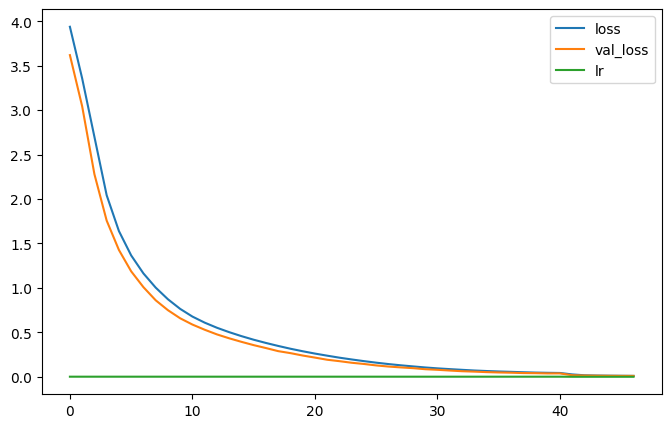

In [16]:
input_vocab_size = len(incorrect_tk.word_index)+1
output_vocab_size = len(correct_tk.word_index)+1

input_len = 16
output_len = 16

lstm_size = 512
att_units = 512
dec_units = 512
embedding_size = 300
score_fun = 'dot'

BATCH_SIZE=512

lr_rate=tf.keras.callbacks.ReduceLROnPlateau(patience=4,min_delta=0.01)
stopping=tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=5)

#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model_1 = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam()
model_1.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//512
valid_steps=validation.shape[0]//512
model_1.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=train_dataloader, validation_steps=valid_steps, callbacks=[lr_rate,stopping,saver])

pd.DataFrame(model_1.history.history).plot(figsize=(8,5))
plt.show()

<font color='blue'>**Inference Code**</font>

In [27]:
def predict_m2(input_sentence):
    
    input_sentence=' '.join(input_sentence.split(' ')[::-1])
    words=[]
    input_sentence=[input_sentence]
    batch_size=1
    tokenized_sent=incorrect_tk.texts_to_sequences(input_sentence)
    #print(tokenized_sent)
    padded_sent=tf.keras.utils.pad_sequences(tokenized_sent, maxlen=16,padding='post' )
    encoder_h, encoder_c=model_1.layers[0].initialize_states(batch_size)
    encoder_output,encoder_h, encoder_c= model_1.layers[0](padded_sent, states=[encoder_h, encoder_c])

    start_index=correct_tk.word_index.get('<start>')
    end_index=correct_tk.word_index.get('<end>')
    for i in range(16):
        decoder_output, decoder_h, decoder_c, attention_weights, context_vector = model_1.layers[1].osd(tf.convert_to_tensor([[start_index]]), encoder_output, encoder_h, encoder_c)
     
        output_index=np.argmax(decoder_output[0])
        start_index=output_index
        #print(output_index)
        encoder_h, encoder_c=decoder_h, decoder_c
        words.append(correct_tk.index_word[output_index])

        #print(list(tknizer_eng.word_index.keys())[output_index])

        if output_index==end_index:
            break;

    return ' '.join(words[:-1])

i=test.iloc[56]['incorrect']
print(i)
predict_m2(i)

i hope you will understand my feeling


'i hope you will understand my feelings'